In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/b2/scratch/ahringer/jj374/lab/relmapping


In [8]:
# Load sites and read counts
fp_sites = 'annot/S1_accessible_sites/S1a_accessible_sites.tsv'
df_sites = pd.read_csv(fp_sites, sep='\t')#.query('(atac_source == "atac_wt_pe") | (atac_source == "atac_wt_se")')
df_sites.head()

,chrom,start,end,atac_mode,atac_source,atac_wt_emb_height,atac_wt_l1_height,atac_wt_l2_height,atac_wt_l3_height,atac_wt_l4_height,...,atac_glp1_d7_rep1_maxcount,atac_glp1_d7_rep2_maxcount,atac_glp1_d10_rep1_maxcount,atac_glp1_d10_rep2_maxcount,atac_glp1_d14_rep1_maxcount,atac_glp1_d14_rep2_maxcount,atac_gon2gem1_ya_rep1_maxcount,atac_gon2gem1_ya_rep2_maxcount,atac_gon2gem1_d3_rep1_maxcount,atac_gon2gem1_d3_rep2_maxcount
0,chrI,1870,2092,1981,atac_wt_se,1.621415,1.459215,1.354735,1.672520,1.204265,...,33.0,33.0,36.0,42.0,28.0,58.0,28.0,32.0,33.0,59.0
1,chrI,3809,3994,3901,atac_wt_pe,61.688004,55.224873,69.346062,123.587425,165.852905,...,1820.0,2072.0,1650.0,2596.0,1316.0,1422.0,2601.0,4677.0,2858.0,2812.0
2,chrI,4302,4410,4356,atac_wt_se,1.458345,2.518715,2.017625,3.193275,5.416205,...,50.0,37.0,67.0,65.0,39.0,58.0,72.0,98.0,59.0,98.0
3,chrI,11245,11465,11355,atac_wt_pe,2.679690,4.330160,9.348130,10.026175,10.876090,...,452.0,554.0,412.0,668.0,314.0,555.0,371.0,458.0,375.0,416.0
4,chrI,13087,13207,13147,atac_wt_pe,5.160855,3.462505,3.761785,3.173980,2.518795,...,53.0,61.0,63.0,116.0,68.0,103.0,76.0,95.0,64.0,95.0


In [9]:
df_sites['atac_source'].value_counts()

atac_wt_pe      30160
atac_glp1_se     6517
atac_wt_se       5568
Name: atac_source, dtype: int64

In [11]:
fp_ = 'annot/S1_accessible_sites/S1a_accessible_sites.wt.bed'
df_sites.query('atac_source != "atac_glp1_se"')[['chrom', 'start', 'end']].to_csv(fp_, sep='\t', index=None, header=None)

fp_ = 'annot/S1_accessible_sites/S1a_accessible_sites.glp1_only.bed'
df_sites.query('atac_source == "atac_glp1_se"')[['chrom', 'start', 'end']].to_csv(fp_, sep='\t', index=None, header=None)

In [3]:
# DESeq on all pairwise combinations of wt stages 
def deseq2x2(df_counts, prefix=None):
    fh_inp, fp_inp = tempfile.mkstemp(dir=os.path.join(os.getcwd(), 'tmp/'), prefix='deseq2x2_inp_')
    fh_out, fp_out = tempfile.mkstemp(dir=os.path.join(os.getcwd(), 'tmp/'), prefix='deseq2x2_out_')
    df_counts.to_csv(fp_inp, sep='\t')
    !cat {fp_inp} | scripts/deseq2x2.R > {fp_out}
    #!wc -l {fp_inp}
    #!wc -l {fp_out}
    #!tail -n 20 {fp_out}
    df_out = pd.read_csv(fp_out, sep='\s+')
    !rm {fp_inp}
    !rm {fp_out}
    if not(prefix is None):
        df_out.columns = [prefix + '_' + column for column in df_out.columns]
    return df_out

def deseq2x2_stages(stages):
    (stage1, stage2) = stages
    return deseq2x2(df_sites[[
        'atac_%s_rep1_count' % (stage1,), 
        'atac_%s_rep2_count' % (stage1,),
        'atac_%s_rep1_count' % (stage2,),
        'atac_%s_rep2_count' % (stage2,),
    ]], prefix = 'atac_%s_to_%s' % (stage1, stage2))

l_pairwise_deseq = pmap(deseq2x2_stages, 
    [(stage1, stage2) for (stage1, stage2) in itertools.combinations(config['stages_wt'], 2)], n_jobs=15)

df_deseq = pd.concat(l_pairwise_deseq, axis=1)

estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
estimating size factors
estimating size factors
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
estimating dispersions
estimating dispersions
gene-wise dispersion estimates
gene-wise dispersion estimates
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion es

[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   22.7s finished


In [5]:
df_fc_padj = pd.DataFrame()
df_incr = pd.DataFrame()
df_decr = pd.DataFrame()
for (stage1, stage2) in itertools.combinations(config['stages_wt'], 2):
    col_log2FoldChange = 'atac_%s_to_%s_log2FoldChange' % (stage1, stage2)
    col_padj = 'atac_%s_to_%s_padj' % (stage1, stage2)
    col_incr = 'atac_%s_to_%s_incr' % (stage1, stage2)
    col_decr = 'atac_%s_to_%s_decr' % (stage1, stage2)
    df_fc_padj[col_log2FoldChange] = df_deseq[col_log2FoldChange]
    df_fc_padj[col_padj] = df_deseq[col_padj]
    df_incr[col_incr] = (df_fc_padj[col_log2FoldChange] > +1) & (df_fc_padj[col_padj] < 0.01)
    df_decr[col_decr] = (df_fc_padj[col_log2FoldChange] < -1) & (df_fc_padj[col_padj] < 0.01)

print(sum(pd.concat([df_incr, df_decr], axis=1).any(axis=1)), 'of', len(df_deseq), 'sites show any change')

26761 of 35728 sites show any change


In [4]:
# DESeq on all pairwise combinations of wt stages (max)
def deseq2x2(df_counts, prefix=None):
    fh_inp, fp_inp = tempfile.mkstemp(dir=os.path.join(os.getcwd(), 'tmp/'), prefix='deseq2x2_inp_')
    fh_out, fp_out = tempfile.mkstemp(dir=os.path.join(os.getcwd(), 'tmp/'), prefix='deseq2x2_out_')
    df_counts.to_csv(fp_inp, sep='\t')
    !cat {fp_inp} | scripts/deseq2x2.R > {fp_out}
    #!wc -l {fp_inp}
    #!wc -l {fp_out}
    #!tail -n 20 {fp_out}
    df_out = pd.read_csv(fp_out, sep='\s+')
    !rm {fp_inp}
    !rm {fp_out}
    if not(prefix is None):
        df_out.columns = [prefix + '_' + column for column in df_out.columns]
    return df_out

def deseq2x2_stages(stages):
    (stage1, stage2) = stages
    return deseq2x2(df_sites[[
        'atac_%s_rep1_maxcount' % (stage1,), 
        'atac_%s_rep2_maxcount' % (stage1,),
        'atac_%s_rep1_maxcount' % (stage2,),
        'atac_%s_rep2_maxcount' % (stage2,),
    ]], prefix = 'atac_%s_to_%s' % (stage1, stage2))

l_pairwise_deseq = pmap(deseq2x2_stages, 
    [(stage1, stage2) for (stage1, stage2) in itertools.combinations(config['stages_wt'], 2)], n_jobs=15)

df_deseq_maxcount = pd.concat(l_pairwise_deseq, axis=1)

estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating size factors
estimating size factors
estimating size factors
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
estimating dispersions
gene-wise dispersion estimates
estimating size factors
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
gene-wise dispersion estimates
estimating dispersions
estimating dispersions
estimating size factors
gene-wise dispersion estimates
gene-wise dispersion estimates
estimating dispe

[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   21.6s finished


In [33]:
df_fc_padj = pd.DataFrame()
df_incr = pd.DataFrame()
df_decr = pd.DataFrame()
for (stage1, stage2) in itertools.combinations(config['stages_wt'], 2):
    col_log2FoldChange = 'atac_%s_to_%s_log2FoldChange' % (stage1, stage2)
    col_padj = 'atac_%s_to_%s_padj' % (stage1, stage2)
    col_incr = 'atac_%s_to_%s_incr' % (stage1, stage2)
    col_decr = 'atac_%s_to_%s_decr' % (stage1, stage2)
    df_fc_padj[col_log2FoldChange] = df_deseq_maxcount[col_log2FoldChange]
    df_fc_padj[col_padj] = df_deseq_maxcount[col_padj]
    df_incr[col_incr] = (df_fc_padj[col_log2FoldChange] > +np.log2(1.5)) & (df_fc_padj[col_padj] < 0.1)
    df_decr[col_decr] = (df_fc_padj[col_log2FoldChange] < -np.log2(1.5)) & (df_fc_padj[col_padj] < 0.1)

print(sum(pd.concat([df_incr, df_decr], axis=1).any(axis=1)), 'of', len(df_deseq), 'sites show any change')

11378 of 35728 sites show any change


In [40]:
len(df_fc_padj.query('atac_wt_emb_to_wt_ya_padj != atac_wt_emb_to_wt_ya_padj'))

15257

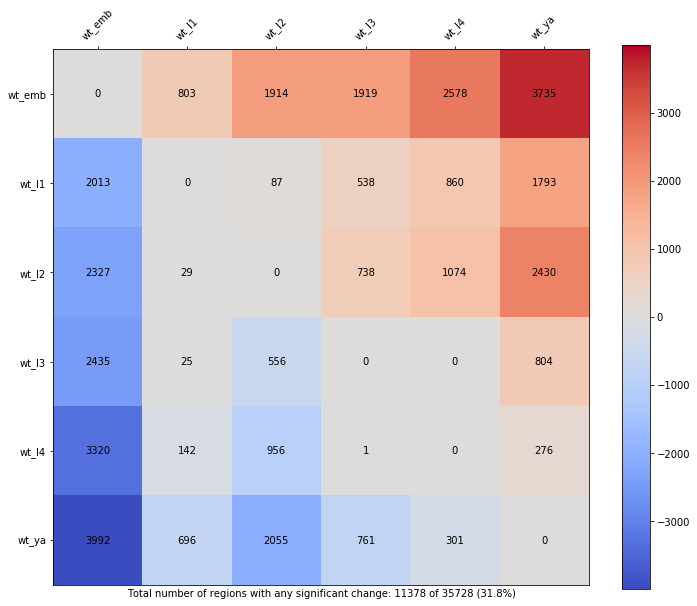

In [34]:
# Define constitutive/dynamic
df_pats = pd.DataFrame()
df_pats[['chrom', 'start', 'end']] = df_sites[['chrom', 'start', 'end']]
l_incr = ['atac_%s_to_%s_incr' % (s1, s2) for (s1, s2) in itertools.combinations(config['stages_wt'], 2)]
l_decr = ['atac_%s_to_%s_decr' % (s1, s2) for (s1, s2) in itertools.combinations(config['stages_wt'], 2)]
m_any = df_diff[l_incr + l_decr].any(axis=1)
df_pats['atac_is_dynamic'] = list(map(lambda f: 'dynamic' if f else 'constitutive', m_any))
df_pats['atac_is_dynamic'].value_counts()

df_diff = pd.concat([df_fc_padj, df_incr, df_decr], axis=1)
diff_counts = np.zeros([len(config['stages_wt']), len(config['stages_wt'])])
for ((stage1_i, stage1), (stage2_i, stage2)) in itertools.combinations(enumerate(config['stages_wt']), 2):
    col_incr = 'atac_%s_to_%s_incr' % (stage1, stage2)
    col_decr = 'atac_%s_to_%s_decr' % (stage1, stage2)
    diff_counts[stage1_i, stage2_i] = len(df_diff.query(col_incr))
    diff_counts[stage2_i, stage1_i] = -len(df_diff.query(col_decr))
    
plt.figure(figsize=(12,10))
ax = plt.gca()
clim = max(-diff_counts.min(), diff_counts.max())
plt.imshow(diff_counts, interpolation='none', cmap = 'coolwarm', vmin=-clim, vmax=+clim)
ax.xaxis.tick_top()
ax.set_xticks(range(len(config['stages_wt'])))
ax.set_yticks(range(len(config['stages_wt'])))
ax.set_xticklabels(config['stages_wt'], rotation=45)
ax.set_yticklabels(config['stages_wt'])
plt.colorbar()
for (y, x), c in np.ndenumerate(diff_counts):
    ax.text(x, y, '%d' % (abs(c),), color='k', horizontalalignment='center', verticalalignment='center')

n_dynamic = len(df_pats.query('atac_is_dynamic == "dynamic"'))
n_all = len(df_pats)
ax.set_xlabel('Total number of regions with any significant change: %d of %d (%.1f%%)' \
              % (n_dynamic, n_all, 100 * n_dynamic / n_all))
#plt.savefig('annot/S1_accessible_sites/differential_accessibility_counts.png' % locals(), bbox_inches='tight')

In [ ]:
fp_out = 'annot/S1_accessible_sites/S1b_differential_accessibility_wt.tsv'
pd.concat([df_sites[['chrom', 'start', 'end']], df_fc_padj, df_incr, df_decr], axis=1).to_csv(fp_out, sep='\t', index=False)
!wc -l {fp_out}